# 조건
- Cum. Return
-St. Dev
- MDD
- CAGR
- annual
- monthly

In [ ]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import pandas_datareader as web
from dateutil.relativedelta import relativedelta

%matplotlib inline

In [ ]:
class Asset():
  def __init__(self, ticker, name, start, end):
    self.ticker = ticker
    self.name = name
    
    self.start = start
    self.end = end

    # 데이터 불러오기
    self.data = web.get_data_yahoo(self.ticker, self.start, self.end)
    self.date = self.data.index

    self.ratio = 0
    self.leverage = 0
    self.price = None
    self.change = None

  def put_ratio_leverage(self, ratio, leverage):
    self.ratio = ratio
    self.leverage = leverage

  def put_price_change(self):
    self.price = self.data['Adj Close']
    self.change = np.multiply(self.price.pct_change().to_list(), [100 * self.leverage])

  def get_date(self):
    return self.date

  def get_change(self):
    return self.change

  def get_name(self):
    return self.name

In [ ]:
class Portfolio():
  def __init__(self, name, assets, ratios, leverages, initial_balance, rebalancing_interval):
    self.name = name
    
    # list of class asset elements
    self.assets = assets

    # Assert all the dates for assets are equal and set portfolio start, end dates
    dates = [each.get_date() for each in self.assets]
    lendates = [len(each) for each in dates]
    assert len(set(lendates)) == 1
    self.date = dates[0]

    self.ratios = [each / sum(ratios) for each in ratios]
    self.leverages = leverages

    for i in range(len(self.assets)):
      self.assets[i].put_ratio_leverage(self.ratios[i], self.leverages[i])
      self.assets[i].put_price_change()

    self.initial_balance = initial_balance  
    self.rebalancing_interval = rebalancing_interval

    self.backtest_df = None
    self.backtest_result_df = None
    self.summary = None

  def backtest(self):
    # 첫 거래일
    balances = []
    for i in range(len(self.assets)):
      balance = [self.initial_balance * self.ratios[i]]
      balances.append(balance)
    
    total_balance = [self.initial_balance]
    next_rebalancing = [self.date[0] + relativedelta(months=self.rebalancing_interval)]

    # 이후 거래일
    for i in range(1, len(self.date)):
      total_balance_tmp = 0

      if self.date[i] >= next_rebalancing[i-1]: # 리밸런싱하는 날
        # 다음 리밸런싱 날짜 추가
        next_rebalancing.append(next_rebalancing[i-1] + relativedelta(months=self.rebalancing_interval))
        for j in range(len(self.assets)):
          balance = total_balance[i-1] * self.ratios[j] * (1 + self.assets[j].get_change()[i] / 100)
          balances[j].append(balance)
          total_balance_tmp += balances[j][i]
      else:
        # 이전 리밸런싱 날짜랑 동일하게
        next_rebalancing.append(next_rebalancing[i-1])
        for j in range(len(self.assets)):
          try:
            balances[j].append(balances[j][i-1] * (1 + self.assets[j].get_change()[i] / 100))
          except:
            balances[j].append(balances[j][i-1])
          total_balance_tmp += balances[j][i]

      total_balance.append(total_balance_tmp)

    df = pd.DataFrame()
    df['Date'] = self.date
    df.set_index('Date', inplace=True)
    df['Total'] = total_balance

    for i in range(len(self.assets)):
      df[self.assets[i].get_name()] = balances[i]
    
    print('Portfolio Backtest Complete')
    self.backtest_df = df

    return df

  def balance_result(self, balance):
    change = [0]
    cum_return = [0]
    prev_high = [0]
    prev_high_tmp = 0
    drawdown = [0]
    mdd = [0]
    mdd_tmp = 0
    CAGR = [0]
    stdev = [0]
    sharpe = [0]

    time_period = (self.date[-1] - self.date[0]).days / 365

    for i in range(1, len(self.date)):
      change.append((balance[i] / balance[i-1] - 1) * 100)
      
      cum_return.append((balance[i] / balance[0] - 1) * 100)

      if prev_high_tmp < cum_return[i]:
        prev_high_tmp = cum_return[i]
      else:
        prev_high_tmp = prev_high_tmp
      prev_high.append(prev_high_tmp)

      CAGR.append(((balance[i] / balance[0]) ** (1 / float(time_period)) - 1) * 100)

      drawdown.append(((cum_return[i] + 100) / (prev_high[i] + 100) - 1) * 100)

      if mdd_tmp > drawdown[i]:
        mdd_tmp = drawdown[i]
      else:
        mdd_tmp = mdd_tmp
      mdd.append(mdd_tmp)

      stdev.append(np.std(change))
      if stdev[i] != 0:
        sharpe.append(np.sqrt(252) * np.mean(change) / np.std(change))
      else:
        sharpe.append(0)

    return change, cum_return, prev_high, CAGR, drawdown, mdd, stdev, sharpe

  def backtest_result(self):
    df = pd.DataFrame()
    df['Date'] = self.date
    df.set_index('Date', inplace=True)
    label = ['Change', 'Cum. Return', 'Prev. High', 'CAGR', 'Drawdown', 'MDD', 'St. Dev', 'Sharpe']

    result = dict()
    for i in self.backtest_df.columns:
      result[i] = self.balance_result(self.backtest_df[i].to_list())
      df[f'{i} Balance'] = self.backtest_df[i].to_list()
      print(f'{i} Complete')
    for j in range(len(label)):
      for i in self.backtest_df.columns:
        df[f'{i} {label[j]}'] = result[i][j]

    self.backtest_result_df = df

    return df
  
  def periodic_result(self, mode):
    df = pd.DataFrame()

    for label in self.backtest_df.columns:
      return_points = []
      returns = []
      start_balance = []
      end_balance = []
      start = self.backtest_df[label].to_list()[0]
      
      if mode == 'annual':
        for i in range(1, len(self.date)):
          if self.date[i].year != self.date[i-1].year:
            return_points.append(self.date[i-1].year)
            returns.append((self.backtest_df[label].to_list()[i-1] / start - 1) * 100)
            start_balance.append(start)
            end_balance.append(self.backtest_df[label].to_list()[i-1])
            start = self.backtest_df[label].to_list()[i]
          elif self.date[i] == self.date[-1]: # 마지막 거래일
            return_points.append(self.date[i].year)
            returns.append((self.backtest_df[label].to_list()[i] / start - 1) * 100)
            start_balance.append(start)
            end_balance.append(self.backtest_df[label].to_list()[i-1])
        df[f'{label} {mode.capitalize()} Return'] = returns
        
      elif mode == 'monthly':
        for i in range(1, len(self.date)):
          if self.date[i].month != self.date[i-1].month:
            return_points.append(self.date[i-1].strftime('%Y-%m'))
            returns.append((self.backtest_df[label].to_list()[i-1] / start - 1) * 100)
            start_balance.append(start)
            end_balance.append(self.backtest_df[label].to_list()[i-1])
            start = self.backtest_df[label].to_list()[i]
          elif self.date[i] == self.date[-1]: # 마지막 거래일
            return_points.append(self.date[i].strftime('%Y-%m'))
            returns.append((self.backtest_df[label].to_list()[i] / start - 1) * 100)
            start_balance.append(start)
            end_balance.append(self.backtest_df[label].to_list()[i-1])
        df[f'{label} {mode.capitalize()} Return'] = returns

    df[f'Return {mode.capitalize()}'] = return_points
    df.set_index(f'Return {mode.capitalize()}', inplace=True)

    print(f'{mode.capitalize()} Result Complete')

    return df

  def get_name(self):
    return self.name

  def get_date(self):
    return self.date

  def get_backtest_result(self):
    return self.backtest_result_df

  def get_summary(self):
    # columns=['Detail', 'Initial Balance', 'Final Balance', 'CAGR', 'MDD', 'St. Dev', 'Sharpe Ratio']
    
    detail = ''
    for i in range(len(self.assets)):
      name = self.assets[i].get_name()
      percentage = int(self.ratios[i] * 100)

      detail += f'{name} ({percentage}%, {self.leverages[i]}x) '

    self.summary = [detail, self.backtest_result_df['Total Balance'][0], self.backtest_result_df['Total Balance'][-1],
                    str(round(self.backtest_result_df['Total CAGR'][-1], 2))+'%', str(round(self.backtest_result_df['Total MDD'][-1], 2))+'%',
                    round(self.backtest_result_df['Total St. Dev'][-1], 2), round(self.backtest_result_df['Total Sharpe'][-1], 2)]
    
    return self.summary

In [ ]:
class Visualize():
  def __init__(self, portfolios):
    self.portfolios = portfolios

     # Assert all the dates for assets are equal and set portfolio start, end dates
    dates = [each.get_date() for each in self.portfolios]
    lendates = [len(each) for each in dates]
    assert len(set(lendates)) == 1
    self.date = dates[0]

  def line_plot(self, result, title, return_type):
    for i in range(len(self.portfolios)):
      plt.plot(self.date, self.portfolios[i].get_backtest_result().loc[:, f'Total {result}'], label=self.portfolios[i].get_name())
    
    plt.title(title)
    plt.legend(loc='best')
    plt.yscale(return_type)
    plt.show()

  def bar_plot(self, title, period):
    for i in range(len(self.portfolios)):
      if period == 'annual':
        result = self.portfolios[i].periodic_result('annual')
        plt.bar(result.index, result.loc[:, 'Total Annual Return'], label=self.portfolios[i].get_name())
      elif period == 'monthly':
        result = self.portfolios[i].periodic_result('monthly')
        plt.bar(result.index, result.loc[:, 'Total Monthly Return'], label=self.portfolios[i].get_name())
    
    plt.title(title)
    plt.legend(loc='best')
    plt.show()

In [ ]:
asset1 = Asset('^IXIC', 'Asset 1', '2016-01-01', '2020-10-31')
asset2 = Asset('VUSTX', 'Asset 2', '2016-01-01', '2020-10-31')

portfolio = Portfolio('60/40', [asset1, asset2], [6, 4], [1, 1], 1000, 3)
backtest_df = portfolio.backtest()
backtest_result_df = portfolio.backtest_result()
annual_return_df = portfolio.periodic_result('annual')
monthly_return_df = portfolio.periodic_result('monthly')
summary = portfolio.get_summary()

Portfolio Backtest Complete
Total Complete
Asset 1 Complete
Asset 2 Complete
Annual Result Complete
Monthly Result Complete


In [ ]:
summary

['Asset 1 (60%, 1x) Asset 2 (40%, 1x) ',
 1000.0,
 1990.5192298202078,
 '15.34%',
 '-17.27%',
 0.73,
 1.29]

In [ ]:
asset3 = Asset('VTI', 'Asset 3', '2016-01-01', '2020-10-31')
asset4 = Asset('EDV', 'Asset 4', '2016-01-01', '2020-10-31')
asset5 = Asset('IEI', 'Asset 5', '2016-01-01', '2020-10-31')
asset6 = Asset('GLD', 'Asset 6', '2016-01-01', '2020-10-31')
asset7 = Asset('GSG', 'Asset 7', '2016-01-01', '2020-10-31')

portfolio2 = Portfolio('All Weather', [asset3, asset4, asset5, asset6, asset7], [3, 4, 1.5, 0.75, 0.75], [1, 1, 1, 1, 1], 1000, 12)
backtest_df2 = portfolio2.backtest()
backtest_result_df2 = portfolio2.backtest_result()
annual_return_df2 = portfolio2.periodic_result('annual')
monthly_return_df2 = portfolio2.periodic_result('monthly')
summary2 = portfolio2.get_summary()

Portfolio Backtest Complete
Total Complete
Asset 3 Complete
Asset 4 Complete
Asset 5 Complete
Asset 6 Complete
Asset 7 Complete
Annual Result Complete
Monthly Result Complete


In [ ]:
summary2

['Asset 3 (30%, 1x) Asset 4 (40%, 1x) Asset 5 (15%, 1x) Asset 6 (7%, 1x) Asset 7 (7%, 1x) ',
 1000.0,
 1526.4247904162778,
 '9.16%',
 '-14.58%',
 0.52,
 1.1]

In [ ]:
aw_64 = Visualize([portfolio, portfolio2])

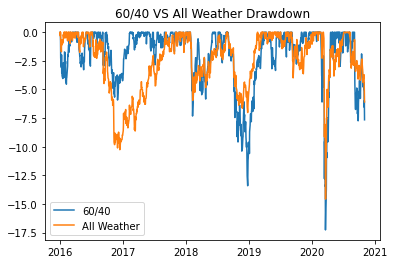

In [ ]:
aw_64.line_plot('Drawdown', '60/40 VS All Weather Drawdown', 'linear')

Monthly Result Complete
Monthly Result Complete


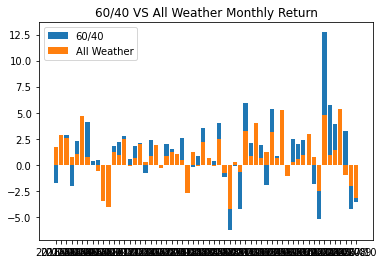

In [ ]:
aw_64.bar_plot('60/40 VS All Weather Monthly Return', 'monthly')